In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

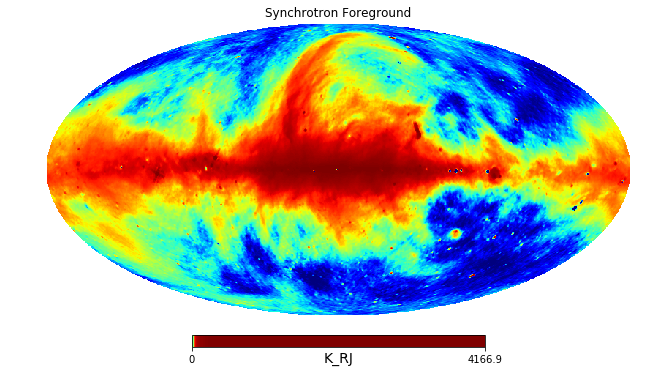

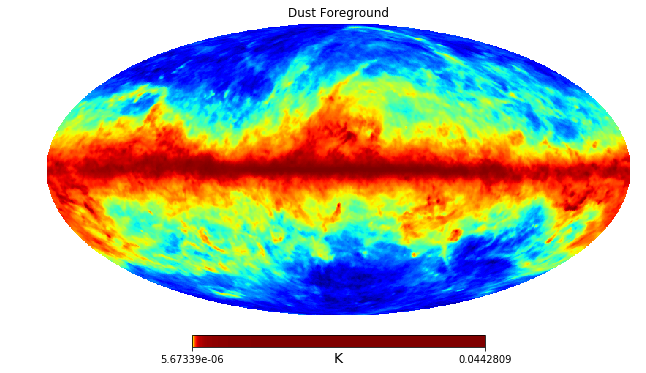

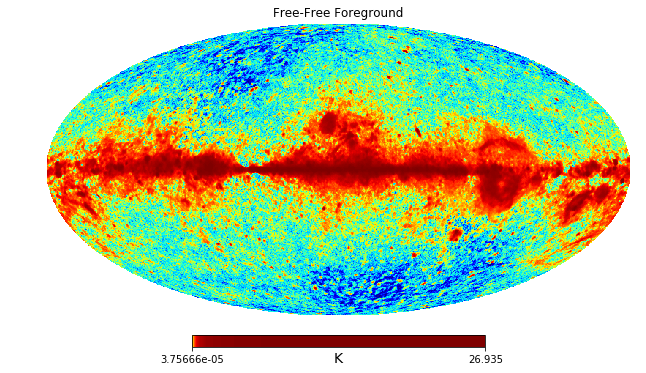

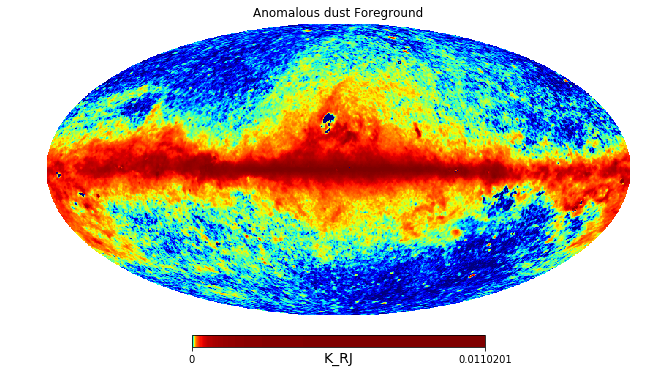

In [2]:
# must check to load the correct column - prefer temp map

FG_synch = hp.read_map("COM_CompMap_Synchrotron-commander_0256_R2.00.fits", dtype=None, verbose=False)        #µK_RJ
#FG_dust  = hp.read_map("COM_CompMap_Dust-GNILC-Model-Temperature_2048_R2.00.fits", dtype=None, verbose=False) #K
FG_dust  = hp.read_map("COM_CompMap_dust-commander_0256_R2.00.fits", dtype=None, field=0, verbose=False)
FG_free  = hp.read_map("COM_CompMap_freefree-commander_0256_R2.00.fits", dtype=None, verbose=False, field=1)  #EM, cm^-6 pc
FG_adust = hp.read_map("COM_CompMap_AME-commander_0256_R2.00.fits", dtype=None, verbose=False, field=0)       #µK_RJ


FG_synch = FG_synch * 10**-6    #µK_RJ to K
FG_dust  = FG_dust  * 10**-6    #µK_RJ to K
FG_adust = FG_adust * 10**-6    #µK_RJ to K

# https://www.cv.nrao.edu/~sransom/web/Ch4.html                 - free-free temp relation

free_factor = (1100/8) * 3.28*(10**-7) * (10**-2.1)

FG_free = (10**3) * ((FG_free * free_factor)**(1/1.35))


#(FG_free / (2.791408895*(10**6)))**(1/1.35) * 10000

if 0==1:
    hp.mollview(
        FG_synch,
        title="Synchrotron Foreground",
        unit="K_RJ",
        norm="hist",
        cmap='jet',)
    hp.mollview(
        FG_dust,
        title="Dust Foreground",
        unit="K",
        norm="hist",
        cmap='jet',)
    hp.mollview(
        FG_free,
        title="Free-Free Foreground",
        unit="K",
        norm="hist",
        cmap='jet',)
    hp.mollview(
        FG_adust,
        title="Anomalous dust Foreground",
        unit="K_RJ",
        norm="hist",
        cmap='jet',)

/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


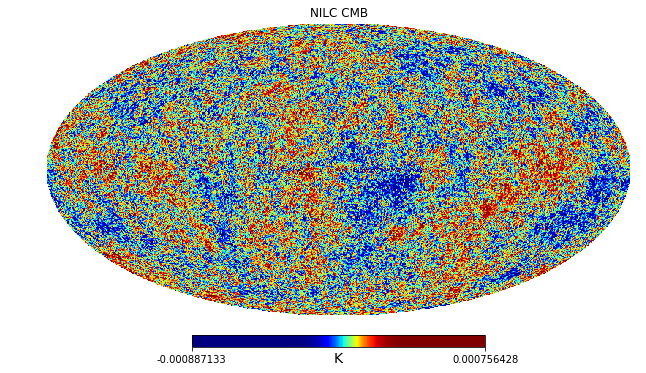

In [3]:
CMB = hp.read_map("COM_CMB_IQU-nilc_2048_R3.00_full.fits", dtype=None, field=0, verbose=False)

hp.mollview(
    CMB,
    title="NILC CMB",
    unit="K",
    norm="hist",
    cmap='jet',
)

# hp.read_map("COM_CMB_IQU-nilc_2048_R3.00_full.fits", dtype=None, h=True)

hp.write_map("NILC_Imap.fits", CMB, overwrite=True)

## Priority signal maps

- Synchrotron
    - not concentrated on galactic plane
    - dominant at less than 70GHz, studied at 20GHz 
    - $ T \propto \nu^\beta  $ where $ 2 < \beta < 3 $
    
    
- Free-free
    - mm and cm range
    - common in ionised hydrogen clouds, can be traced by their emission lines
    - $ T ∝ \nu^ {-\beta} $, where $  \beta \approx 2 $
    
    
- Galactic Dust
    - greybody emission in far IR
    - high variation in emissivity
    - $ T ∝ T_0  \nu^\beta, $ given $  \beta \approx 2 $, where $T_0$ and $\beta$ vary over the sky
    

In [4]:
def synthmap(freq):
    
    # each foreground map has its own reference frequency it works against
    
    freq_synch = 0.408 # GHz
    freq_dust  = 545
    freq_free  = 4
    freq_adust = 22.8
    
    # conversion:
    # https://www.aanda.org/articles/aa/pdf/2016/10/aa26803-15.pdf
    
    new_synch = FG_synch * (freq / freq_synch)**-3.1    # 3
    new_dust  = FG_dust  * (freq / freq_dust)**3        # 2
    new_free  = FG_free  * (freq / freq_free)**-2.14    # -2.14
    new_adust = FG_adust * (freq / freq_adust)**-2.5    # -2.5
    
    # CMB conversion factor?
    
    combined_map = new_synch + new_dust + new_free + new_adust + CMB
    
    
    # debugging
    
    if 0==1:
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(16,6))
        
        plt.sca(ax1)
        hp.mollview(    new_synch,    title="Synchro",    unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax2)
        hp.mollview(    new_adust,    title="A-dust",     unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax3)
        hp.mollview(    new_free,     title="Free-free",  unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax4)
        hp.mollview(    new_dust,     title="Dust",       unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax5)
        hp.mollview(    CMB,          title="NILC CMB",   unit="K",    norm="hist",    cmap='jet', hold=True)
    
    
    
    return combined_map
    
def rescale(map, NSIDE):
    
    rescaled = hp.ud_grade(map, NSIDE)
    
    return rescaled

In [5]:
NSIDE = 512

FG_synch = rescale(FG_synch, NSIDE)
FG_dust  = rescale(FG_dust, NSIDE)
FG_free  = rescale(FG_free, NSIDE)
FG_adust = rescale(FG_adust, NSIDE)

CMB = rescale(CMB, NSIDE)

CMB_30_p  = hp.read_map("LFI_SkyMap_030-field-IQU_1024_R3.00_full.fits",     dtype=None, verbose=False)
CMB_70_p  = hp.read_map("LFI_SkyMap_070-field-IQU_1024_R3.00_full.fits",     dtype=None, verbose=False)
CMB_143_p = hp.read_map("HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits",     dtype=None, verbose=False)
CMB_353_p = hp.read_map("HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits", dtype=None, verbose=False)


In [6]:
synth_30  = synthmap(30)
synth_70  = synthmap(70)
synth_143 = synthmap(143)
synth_353 = synthmap(353)




In [7]:
def synthmod_map(freq):
    
    # each foreground map has its own reference frequency it works against
    
    freq_synch = 0.408 # GHz
    freq_dust  = 545
    freq_free  = 4
    freq_adust = 22.8
    
    # conversion:
    # https://www.aanda.org/articles/aa/pdf/2016/10/aa26803-15.pdf
    
    new_synch = FG_synch * (freq / freq_synch)**-3.1        # 3
    new_dust  = FG_dust  * (freq / freq_dust)**3     * 10   # 2
    new_free  = FG_free  * (freq / freq_free)**-2.14        # -2.14
    new_adust = FG_adust * (freq / freq_adust)**-2.5        # -2.5
    
    # CMB conversion factor?
    
    combined_map = new_synch + new_dust + new_free + new_adust + CMB
    
    
    # debugging
    
    if 0==1:
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(16,6))
        
        plt.sca(ax1)
        hp.mollview(    new_synch,    title="Synchro",    unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax2)
        hp.mollview(    new_adust,    title="A-dust",     unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax3)
        hp.mollview(    new_free,     title="Free-free",  unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax4)
        hp.mollview(    new_dust,     title="Dust",       unit="K",    norm="hist",    cmap='jet', hold=True)
        plt.sca(ax5)
        hp.mollview(    CMB,          title="NILC CMB",   unit="K",    norm="hist",    cmap='jet', hold=True)
    
    
    
    return combined_map

synth_30m  = synthmod_map(30)
synth_70m  = synthmod_map(70)
synth_143m = synthmod_map(143)
synth_353m = synthmod_map(353)

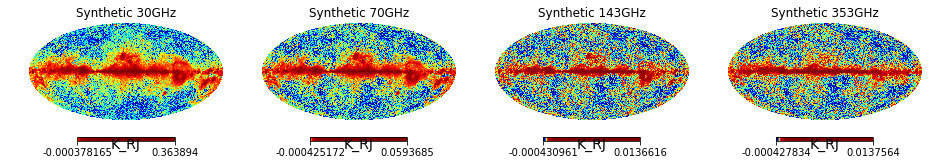

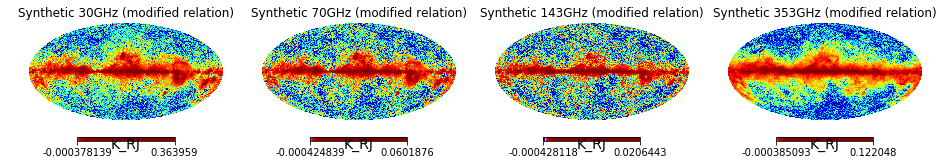

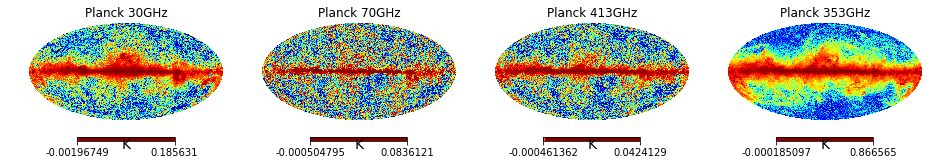

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,6))

plt.sca(ax1)
hp.mollview(
    synth_30,
    title="Synthetic 30GHz",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax2)
hp.mollview(
    synth_70,
    title="Synthetic 70GHz",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax3)
hp.mollview(
    synth_143,
    title="Synthetic 143GHz",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax4)
hp.mollview(
    synth_353,
    title="Synthetic 353GHz",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,6))

plt.sca(ax1)
hp.mollview(
    synth_30m,
    title="Synthetic 30GHz (modified relation)",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax2)
hp.mollview(
    synth_70m,
    title="Synthetic 70GHz (modified relation)",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax3)
hp.mollview(
    synth_143m,
    title="Synthetic 143GHz (modified relation)",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax4)
hp.mollview(
    synth_353m,
    title="Synthetic 353GHz (modified relation)",
    unit="K_RJ",
    norm="hist",
    cmap='jet',
    hold=True
)

fig, (ax5, ax6, ax7, ax8) = plt.subplots(1,4,figsize=(16,6))

plt.sca(ax5)
hp.mollview(
    CMB_30_p,
    title="Planck 30GHz",
    unit="K",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax6)
hp.mollview(
    CMB_70_p,
    title="Planck 70GHz",
    unit="K",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax7)
hp.mollview(
    CMB_143_p,
    title="Planck 413GHz",
    unit="K",
    norm="hist",
    cmap='jet',
    hold=True
)

plt.sca(ax8)
hp.mollview(
    CMB_353_p,
    title="Planck 353GHz",
    unit="K",
    norm="hist",
    cmap='jet',
    hold=True
)

In [9]:
hp.write_map("synthetic_30GHz.fits", synth_30, overwrite=True)
hp.write_map("synthetic_70GHz.fits", synth_70, overwrite=True)
hp.write_map("synthetic_143GHz.fits", synth_143, overwrite=True)
hp.write_map("synthetic_353GHz.fits", synth_353, overwrite=True)

hp.write_map("synthetic_30GHz_m.fits", synth_30m, overwrite=True)
hp.write_map("synthetic_70GHz_m.fits", synth_70m, overwrite=True)
hp.write_map("synthetic_143GHz_m.fits", synth_143m, overwrite=True)
hp.write_map("synthetic_353GHz_m.fits", synth_353m, overwrite=True)

In [10]:
def harmonic(pmap, LMAX):
    
    hmap = hp.map2alm(pmap, lmax=LMAX)
    
    return hmap

def cov_inv(hmaps):
    
    maps_stack = np.stack(hmaps)
    
    stack_cut = np.delete(maps_stack, obj=0, axis=1)
    
    C_lm = np.cov(stack_cut)
    C_inv = np.linalg.inv(C_lm)
    
    return C_inv

def weight_gen(C_inv):
    
    numerator = np.sum(C_inv, axis=0)  
    
    denominator = np.sum(numerator) 
    
    w = numerator / denominator

    
    w_tot = np.sum(w)
    
    print("The total weight is:",w_tot,)
    
    return w

def output_map(hmaps, w, LMAX, NSIDE):
       
    weighted_maps = np.empty(shape=np.shape(hmaps), dtype=np.complex_)
    
    print(np.shape(hmaps))
    
    for i in range(len(w)):
        row_slice = hmaps[i]
        weighted_maps[i] = row_slice * w[i]
        
    hmap = np.sum(weighted_maps, axis = 0)
    
    fin_map = hp.alm2map(hmap, lmax=LMAX, nside= NSIDE)
    
    return fin_map

In [ ]:
LMAX = 2000

synth_30_h  = harmonic(synth_30,  LMAX)
synth_70_h  = harmonic(synth_70,  LMAX)
synth_143_h = harmonic(synth_143, LMAX)
synth_353_h = harmonic(synth_353, LMAX)

map_set = (synth_30_h,synth_70_h,synth_143_h,synth_353_h)
                       
a = cov_inv(map_set)
weights = weight_gen(a)
print("The weights directly:",weights)

recovered_CMB = output_map(map_set, weights, LMAX, NSIDE)

In [19]:
synth_30m_h  = harmonic(synth_30m,  LMAX)
synth_70m_h  = harmonic(synth_70m,  LMAX)
synth_143m_h = harmonic(synth_143m, LMAX)
synth_353m_h = harmonic(synth_353m, LMAX)

map_set_m = (synth_30m_h,synth_70m_h,synth_143m_h,synth_353m_h)
                       
a_m = cov_inv(map_set_m)
weights_m = weight_gen(a_m)
print("The weights directly:",weights_m)

recovered_CMB_m = output_map(map_set_m, weights_m, LMAX, NSIDE)

The total weight is: (0.9999999999999999+0j)
The weights directly: [ 0.0924322 +0.09436788j -1.0044705 -0.71927392j  2.04219682+0.667002j
 -0.13015852-0.04209597j]
(4, 2003001)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


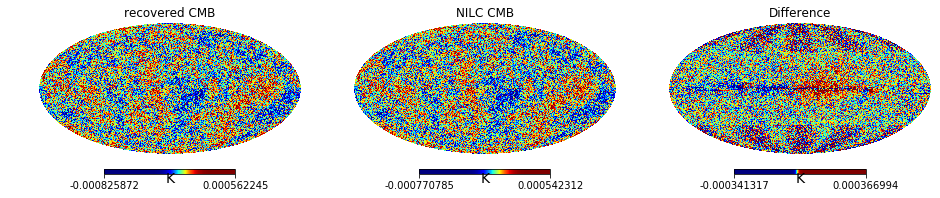

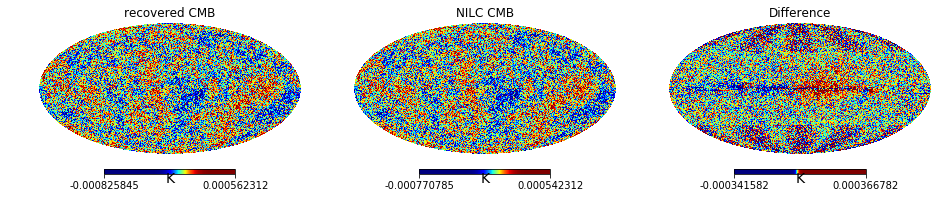

In [20]:
delta_CMB = recovered_CMB - CMB

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,5))

plt.sca(ax1)
hp.mollview(recovered_CMB, title="recovered CMB", unit="K", norm="hist", cmap='jet', hold=True)

plt.sca(ax2)
hp.mollview(CMB,           title="NILC CMB",      unit="K", norm="hist", cmap='jet', hold=True)

plt.sca(ax3)
hp.mollview(delta_CMB,     title="Difference",    unit="K", norm="hist", cmap='jet', hold=True)


delta_CMB_m = recovered_CMB_m - CMB

fig, (ax4, ax5, ax6) = plt.subplots(1,3,figsize=(16,5))

plt.sca(ax4)
hp.mollview(recovered_CMB_m, title="recovered CMB", unit="K", norm="hist", cmap='jet', hold=True)

plt.sca(ax5)
hp.mollview(CMB,             title="NILC CMB",      unit="K", norm="hist", cmap='jet', hold=True)

plt.sca(ax6)
hp.mollview(delta_CMB_m,     title="Difference",    unit="K", norm="hist", cmap='jet', hold=True)

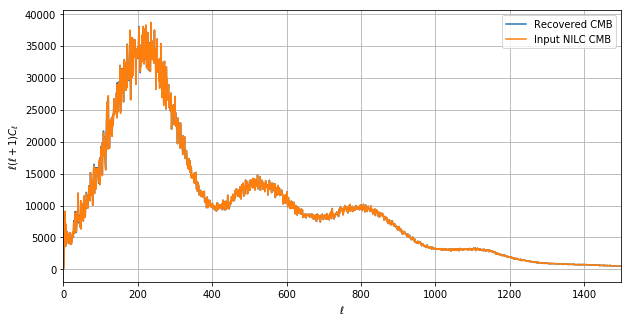

In [24]:
power = 10**12

recovered_CMB_n = hp.anafast(recovered_CMB, lmax=LMAX) * power
CMB_n = hp.anafast(CMB, lmax=LMAX) * power

ell = np.arange(len(recovered_CMB_n))

plt.figure(figsize=(10, 5))

plt.plot(ell, ell * (ell + 1) * recovered_CMB_n, label="Recovered CMB")
plt.plot(ell, ell * (ell + 1) * CMB_n, label="Input NILC CMB")
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.xlim(0,1500)
plt.legend()
plt.grid()
#plt.yticks([])